In [1]:
#https://www.youtube.com/watch?v=ne-dpRdNReI
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn import preprocessing
from collections import deque, OrderedDict
import random
import fastai
from utils.pydataset import *
from utils.clr import *
from utils.pydataset import *
from fastai.dataloader import *

import matplotlib.pyplot as plt
from scipy import signal
%matplotlib inline
# from fastai.old.fastai.column_data import *
# from fastai.metrics import accuracy

In [316]:
use_cuda = torch.cuda.is_available(); print(use_cuda)
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
CUDA_LAUNCH_BLOCKING=1

True


In [2]:
PATH = Path("../data")
sets = ["BTC-USD", "BCH-USD", "ETH-USD", "LTC-USD"]
wash = False

In [3]:
seq_len = 60 #transactions prior to prediction point
pred_period = 2 #minutes ahead to predict 
pred_ratio = "LTC-USD"
val_pct = .1
bs = 20
epochs = 20

In [4]:
def prep_df(df):
    df = df.copy().drop("future",1)
    
    for col in df.columns:
        if col != "target":
            df[col] = df[col].pct_change()
            df.dropna(inplace=True)
            df[col] = preprocessing.scale(df[col].values)
    sequential_data = []
    prev_period = deque(maxlen=seq_len)
    buys = []
    sells = []
    for i in df.values:
        prev_period.append([n for n in i[:-1]])
        if len(prev_period) == seq_len:
#             sequential_data.append([np.array(prev_period), i[-1]])
            if i[-1] == 0:
                sells.append([np.array(prev_period),np.array(i[-1])])
            elif i[-1] == 1:
                buys.append([np.array(prev_period),np.array(i[-1])])
    print(len(buys),len(sells))
    lower = min(len(buys), len(sells))
    buys = buys[:lower-1]
    sells = sells[:lower-1]
    balanced = buys+sells
    random.shuffle(balanced)
    data = OrderedDict()
    labels = OrderedDict()
    for i, (seq, targ) in enumerate(balanced):
        data[i] = seq
        labels[i] =targ
    print(f"Total: {len(balanced)}, Buys: {len(buys)}, Sells: {len(sells)}")
    
    return data, labels

def classify(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0

In [5]:
if wash:
    df_s = [pd.read_csv(PATH / f"{s}.csv",
                        names = ["time","low","high","open",f"{s}_close",f"{s}_volume"],
                        index_col=["time"]).drop(["low","high","open"], axis=1) for s in sets]
    df_m = pd.concat(df_s, axis=1, join="inner")
    
    df_m["future"] = df_m[f"{pred_ratio}_close"].shift(-pred_period)
    df_m["future"].fillna(method="ffill",inplace=True)
    df_m["target"] = list(map(classify,df_m[f"{pred_ratio}_close"],df_m["future"]))
    df_m.sort_index(inplace=True)
    val_idx = int(len(df_m) * val_pct)
    df_v = df_m.iloc[-val_idx:].copy()
    df_t = df_m.iloc[:-val_idx].copy()
    
    train_x, train_y = prep_df(df_t)
    val_x, val_y = prep_df(df_v)
    
    qdf = pd.DataFrame([train_x, train_y]).T
    qdf.to_pickle(PATH / f'T_proc_crypto_{seq_len}_{val_pct * 100}.pkl')
    qdf = pd.DataFrame([val_x, val_y]).T
    qdf.to_pickle(PATH / f'V_proc_crypto_{seq_len}_{val_pct * 100}.pkl')
else:
    df_t= pd.read_pickle(PATH / f'T_proc_crypto_{seq_len}_{val_pct * 100}.pkl')
    train_x = df_t.loc[:,0].to_dict(OrderedDict)
    train_y = df_t.loc[:,1].to_dict(OrderedDict)
    df_v =pd.read_pickle(PATH / f'V_proc_crypto_{seq_len}_{val_pct * 100}.pkl') 
    val_x = df_v.loc[:,0].to_dict(OrderedDict)
    val_y = df_v.loc[:,1].to_dict(OrderedDict)

In [6]:
class Dataset(data.Dataset):
    def __init__(self, data, labels):
        super().__init__()
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [7]:
trn_ds = Dataset(train_x, train_y)
val_ds = Dataset(val_x, val_y)

trn_dl = DataLoader(trn_ds, batch_size=bs)
val_dl = DataLoader(val_ds, batch_size=bs)

In [9]:
class GRU(nn.Module):
    def __init__(self, h_dim, out_size):
        super(GRU, self).__init__()
        
        self.h_dim = h_dim
        self.out_sz = out_size
        
        self.gru = nn.GRU(8, self.h_dim)
        self._lin1 = nn.Linear(self.h_dim * seq_len, self.out_sz)
        
    def forward(self, input):
        hidden = self.initHidden(input.shape[1])
        _, hn = self.gru(input, hidden)
        ## from (1, N, hidden) to (N, hidden)
        rearranged = hn.view(bs, -1)
        out1 = self._lin1(rearranged)
        return out1
        
    def initHidden(self, N):
        return Variable(torch.randn(1, N, self.h_dim))

In [8]:
class lstmclass(nn.Module):
    def __init__(self,n_layers,h_dim,GRU=False):
        super().__init__()
        self.n_layers = n_layers
        self.h_dim = h_dim
        if GRU:
            self.gru = nn.GRU(8, h_dim, n_layers,bias=False,batch_first=True)
        else:
            self.lstm = nn.LSTM(8, h_dim, n_layers, batch_first=True)
            self.h_dim = h_dim * self.n_layers
        self.subs = nn.ModuleList([
                            nn.Linear(h_dim, h_dim//2),
                            nn.Dropout(.2),
                            nn.Linear(h_dim//2, h_dim//4),
                            nn.Dropout(.1),
                            nn.Linear(h_dim//4,1)])
        
    def forward(self, x):
        h = self._init_hidden(x)
        if self.gru:
            x, h = self.gru(x, h[0])
            x = h[0]
        else:
            x, h = self.lstm(x, h)
            x = h[0].view(bs, self.h_dim * self.n_layers)
            
        for lay in self.subs:
            x = lay(x)
        x = F.sigmoid(x)
        return x
    
    def _init_hidden(self, x):
        return (Variable(torch.randn(self.n_layers, x.size()[0], self.h_dim)),
                Variable(torch.randn(self.n_layers, x.size()[0], self.h_dim)))

In [11]:
# class LSTM(nn.Module):
#     def __init__(self,h_dim,h_layers):
#         super().__init__()
#         self.h_dim = h_dim
#         self.h_layers = h_layers
#         self.lstm = nn.LSTM(8,h_dim,h_layers,batch_first=True)
#         self.lin1 = nn.Linear(h_dim, h_dim//2)
#         self.bn = nn.BatchNorm1d(seq_len)
#         self.drop = nn.Dropout(.1)
#         self.lin2 = nn.Linear(h_dim//2, 1)
    
#     def forward(self, x):
#         hidden = Variable(torch.zeros(2,self.h_layers, x.size(0), self.h_dim).cuda())
#         print(hidden.shape)
#         self.lstm.flatten_parameters()
#         return x
#         x, h = self.lstm(x,hidden)
#         x = x.contiguous().view(-1,np.prod(x.size()[1:]))
#         x = self.lin1(x)
#         x = F.relu(self.bn(x))
#         x = self.drop(x)
# #         x = x.view(bs,-1)
#         x = F.softmax(self.lin2(x), dim=1)
#         return x

In [15]:
def append_stats(ep_vals, epoch, values, decimals=6):
    ep_vals[epoch]=list(np.round(values, decimals))
    return ep_vals

def print_stats(epoch, values, decimals=3):
    layout = "{!s:^10}" + " {!s:10}" * len(values)
    values = [epoch] + list(np.round(values, decimals))
    print(layout.format(*values))
    
def accuracy(input, targs):
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    return (input==targs).float().mean()

# names = ["ep / it","trn_loss","val_loss"]
names = ["ep / it", "trn_loss","lwst_trn","val_loss","accuracy"]
layout = "{!s:10} " * len(names)

In [18]:
# net = GRU(64, 1)
# net = LSTM(128,1)
net = lstmclass(4,64, True)

use_cuda=False
if use_cuda:
    net.cuda()
lr = 2e-6

optim = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.MSELoss()
window = 200
scheduler = CyclicLR(optim, lr, step_size=len(trn_ds)*2, mode='triangular2')

In [14]:
# batch, ys = next(iter(trn_dl))
# h = (Variable(torch.zeros(1, bs, 64)),
#           Variable(torch.zeros(1,bs, 64)))
# tst1 = nn.LSTM(8, 64, 1, batch_first=True)

# x, h = tst1(Variable(batch.float()), h)
# x.shape

torch.Size([10, 60, 64])

In [35]:
val_it = iter(val_dl)
v_bat, v_ys = next(val_it)                
v_bat = Variable(v_bat.type(dtype))
v_ys = Variable(v_ys.type(dtype))
net.eval()
with torch.no_grad():
    v = net(v_bat)
list(zip(v,v_ys))

[(tensor([ 0.4628]), tensor(1.)),
 (tensor([ 0.8985]), tensor(1.)),
 (tensor([ 0.9149]), tensor(1.)),
 (tensor([ 0.1681]), tensor(1.)),
 (tensor([ 0.9868]), tensor(0.)),
 (tensor([ 0.6077]), tensor(0.)),
 (tensor([ 0.4122]), tensor(1.)),
 (tensor([ 0.6049]), tensor(1.)),
 (tensor([ 0.8046]), tensor(0.)),
 (tensor([ 0.7168]), tensor(1.)),
 (tensor([ 0.5092]), tensor(0.)),
 (tensor([ 0.8839]), tensor(1.)),
 (tensor([ 0.2126]), tensor(1.)),
 (tensor([ 0.2989]), tensor(0.)),
 (tensor([ 0.3471]), tensor(0.)),
 (tensor([ 0.7692]), tensor(0.)),
 (tensor([ 0.3033]), tensor(1.)),
 (tensor([ 0.3951]), tensor(1.)),
 (tensor([ 0.9235]), tensor(0.)),
 (tensor([ 0.3788]), tensor(1.))]

In [14]:
# checkpoint = torch.load(PATH / f"checks/gru_{net.base}_{net.sub}_{net.n_layers}x{net.start_dim}_clr.pth.tar")
# if not net.gru.bias:
#     keys = [ "gru.bias_ih_l0", "gru.bias_hh_l0", "gru.bias_ih_l1", "gru.bias_hh_l1"]
#     for key in keys:
#         del checkpoint['state_dict'][key]
# net.load_state_dict(checkpoint['state_dict'])
# optim.load_state_dict(checkpoint['optimizer'])
# scheduler.load_dict(checkpoint['scheduler'])

In [13]:
def save_checkpoint(name, is_best):
    filename =f"{name}_{net.n_layers}x{net.h_dim}_clr.pth.tar"
    state = {'epoch': epochs,
            'last_epoch': epoch,
            'arch': filename,
            'state_dict': net.state_dict(),
            'losses': [t_ls,v_ls],
            'optimizer': optim.state_dict(),
            'scheduler': scheduler.__dict__}

    torch.save(state, PATH / f'checks/{filename}')
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')
    print('Checkpoint saved.')

In [16]:
t_ls = []
v_ls = []
accs = []
ep_vals = OrderedDict()

In [ ]:
for epoch in range(epochs):
    if epoch == 0: print(layout.format(*names))
    val_it = iter(val_dl)
    for i, (batch, ys) in enumerate(trn_dl, 0):
        scheduler.batch_step()
        if use_cuda:
            dtype = torch.cuda.FloatTensor
        else:
            dtype = torch.FloatTensor
        
        batch = Variable(batch.type(dtype))
        ys = Variable(ys.type(dtype))
        net.train()
        pred = net(batch)
#         ls = loss(pred, ys)
        ls = loss(pred, torch.unsqueeze(ys, dim=1))
        optim.zero_grad()
        ls.backward()
        t_ls.append(ls.item())
        optim.step()
        vals = [np.mean(t_ls[-window:])]

        if i % window == 0:
            net.eval()
            with torch.no_grad():
                v_bat, v_ys = next(val_it)
                
                v_bat = Variable(v_bat.type(dtype))
                v_ys = Variable(v_ys.type(dtype))
                v = net(v_bat)
                v_loss = loss(v, torch.unsqueeze(v_ys, dim=1))
                v_ls.append(v_loss.item())
                accs.append(accuracy(v, v_ys.long()))
                
#             vals.append(v_loss.item())
            min_t_l = np.min(t_ls[-window:])
            vals.extend((min_t_l, v_loss.item(), accs[-1]))
#             vals.extend((v_loss.item(), np.mean(accs[-3:])))
            print_stats(f"{epoch+1} / {i+1}",vals,4)
    
    save_checkpoint('gru', False)
    ep_vals = append_stats(ep_vals, epoch+1, vals)

ep / it    trn_loss   lwst_trn   val_loss   accuracy   
  1 / 1    0.2098     0.1038     0.3699     0.4       
 1 / 201   0.2087     0.118      0.3404     0.3       
 1 / 401   0.2082     0.1274     0.2853     0.4       
 1 / 601   0.2023     0.1184     0.2687     0.5       
 1 / 801   0.2065     0.102      0.2756     0.55      
 1 / 1001  0.208      0.1286     0.1982     0.5       
 1 / 1201  0.1968     0.1082     0.2514     0.55      
 1 / 1401  0.2099     0.1139     0.3173     0.65      
 1 / 1601  0.2076     0.0861     0.2488     0.4       
 1 / 1801  0.2088     0.1068     0.3693     0.5       
 1 / 2001  0.2065     0.1077     0.3232     0.45      
 1 / 2201  0.2144     0.1311     0.2763     0.35      
 1 / 2401  0.209      0.0983     0.2408     0.4       
 1 / 2601  0.2066     0.1334     0.308      0.55      
 1 / 2801  0.2116     0.1286     0.269      0.5       
 1 / 3001  0.2108     0.1189     0.3565     0.45      
Checkpoint saved.
  2 / 1    0.2057     0.1176     0.3419     0.

 10 / 201  0.246      0.1853     0.2515     0.3       
 10 / 401  0.2478     0.2085     0.2472     0.4       
 10 / 601  0.2467     0.1943     0.2521     0.5       
 10 / 801  0.2469     0.1966     0.2411     0.55      
10 / 1001  0.2471     0.2057     0.2334     0.5       
10 / 1201  0.2448     0.2084     0.2561     0.55      
10 / 1401  0.2478     0.2091     0.2314     0.65      
10 / 1601  0.2471     0.176      0.2272     0.4       
10 / 1801  0.2483     0.201      0.2353     0.5       
10 / 2001  0.2473     0.2078     0.2381     0.45      
10 / 2201  0.2457     0.1923     0.2362     0.35      
10 / 2401  0.2464     0.1989     0.2345     0.4       
10 / 2601  0.2453     0.2003     0.2275     0.55      
10 / 2801  0.2445     0.185      0.2488     0.5       
10 / 3001  0.2481     0.1815     0.2523     0.45      
Checkpoint saved.
  11 / 1   0.2451     0.199      0.2889     0.4       
 11 / 201  0.2455     0.1969     0.2603     0.3       
 11 / 401  0.2484     0.2127     0.2511     0.4

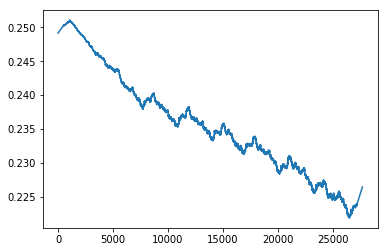

In [34]:
# data= t_ls[10:-5]
x = range(len(data))
y = data

plt.plot(x, signal.savgol_filter(y,1001,1))
plt.show()

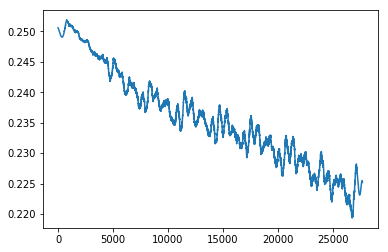

In [32]:
data= t_ls[:-5]
x = range(len(data))
y = data

plt.plot(x, signal.savgol_filter(y,1001,5))
plt.show()

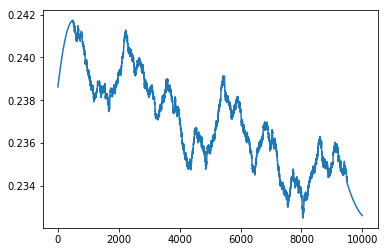

In [30]:
data= t_ls[-10000:]
x = range(len(data))
y = data

plt.plot(x, signal.savgol_filter(y,1001,2))
plt.show()